<a href="https://colab.research.google.com/github/annasree/Sentiment-Analysis-/blob/main/7PAM2015_0105_2023_Assignment_3_Individual_project_Large_Language_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This project train, deploy and fine-tune a BERT-style LLM to do sentiment analysis of amazone customer reviews, data taken from kaggle.

In [47]:
# import necessory modules
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler




Step 1 : In the first step we loaded the data and done some data preprocessing like identifying and filling the missing values. Also done some exploratory data anlysis.

In [48]:
# import data
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/archive (16).zip" -d "/content/drive/MyDrive/Sentiment_Analysis_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/archive (16).zip
  inflating: /content/drive/MyDrive/Sentiment_Analysis_data/amazon_reviews.csv  


In [49]:
# Load data
data_path = "/content/drive/MyDrive/Sentiment_Analysis_data/amazon_reviews.csv"
df = pd.read_csv(data_path)


In [50]:
# print the first 5 rows
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [51]:
# Keep only the necessary columns for sentiment analysis
sentiment_df = df[['verified_reviews', 'feedback']].copy()

# Rename columns
sentiment_df.columns = ['Review', 'Sentiment']

# Print a sample of the new DataFrame
print(sentiment_df.head())

                                              Review  Sentiment
0                                      Love my Echo!          1
1                                          Loved it!          1
2  Sometimes while playing a game, you can answer...          1
3  I have had a lot of fun with this thing. My 4 ...          1
4                                              Music          1


In [52]:
# Print some positive reviews
print("Positive Reviews:")
positive_reviews = sentiment_df[sentiment_df['Sentiment'] == 1]['Review'].head(3)
for review in positive_reviews:
    print(review)

# Print some negative reviews
print("\nNegative Reviews:")
negative_reviews = sentiment_df[sentiment_df['Sentiment'] == 0]['Review'].head(3)
for review in negative_reviews:
    print(review)


Positive Reviews:
Love my Echo!
Loved it!
Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.

Negative Reviews:
It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals.
Sound is terrible if u want good music too get a bose
Not much features.


In [53]:
# print data info
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     3149 non-null   object
 1   Sentiment  3150 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.3+ KB


In [54]:
# Check for missing values
missing_values = sentiment_df.isnull().sum()
print(missing_values)

Review       1
Sentiment    0
dtype: int64


In [55]:
# Fill missing value
sentiment_df['Review'].fillna('Not available', inplace=True)

In [56]:
# Check for missing values
missing_values = sentiment_df.isnull().sum()
print(missing_values)

Review       0
Sentiment    0
dtype: int64


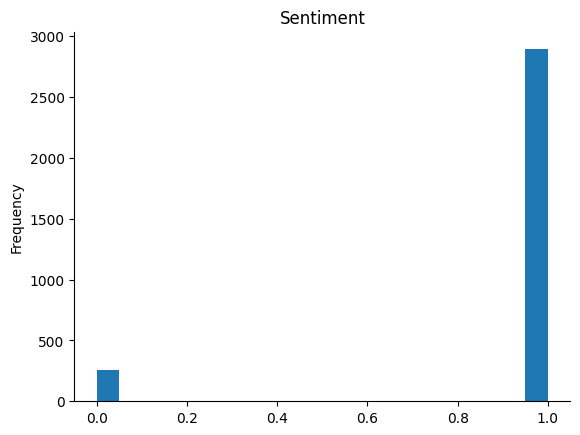

In [57]:
# ploting the frequency of positive and negative reviews
sentiment_df['Sentiment'].plot(kind='hist', bins=20, title='Sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

Step 2: Prepare the data for training, evaluation and testing, Splitted the data into train, validation and test sets, tokenized and encoded the input text data and created the dataloaders.

In [58]:
# Split the data into features (X) and target (y)
X = sentiment_df['Review']
y = sentiment_df['Sentiment']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Create DataFrames for train, validation, and test sets
train_df = pd.DataFrame({'Review': X_train, 'Sentiment': y_train})
val_df = pd.DataFrame({'Review': X_val, 'Sentiment': y_val})
test_df = pd.DataFrame({'Review': X_test, 'Sentiment': y_test})

In [59]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 128

# Tokenize and encode the text data
def tokenize_and_encode(texts):
    input_ids = []
    attention_masks = []
    for text in texts:
        # Tokenize text
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = max_length,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                       )
        # Add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Tokenize and encode training data
train_input_ids, train_attention_masks = tokenize_and_encode(X_train)

# Tokenize and encode validation data
val_input_ids, val_attention_masks = tokenize_and_encode(X_val)

# Tokenize and encode test data
test_input_ids, test_attention_masks = tokenize_and_encode(X_test)

# Create DataLoaders for training, validation, and test data
batch_size = 32

# Training DataLoader
train_labels = torch.tensor(y_train.values)  # Convert y_train to numpy array and then to PyTorch tensor
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)


# Validation DataLoader
val_labels = torch.tensor(y_val.values)  # Convert y_val to numpy array and then to PyTorch tensor
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

# Test DataLoader
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Step 3: Loaded the pre-trained BERT model, Fine-Tuned the pre-trained BERT model by adding dropout layer and unfreezing some layers, model trainig, evaluation and testing

In [60]:
# Number of unique labels (sentiments)
num_labels = len(train_df['Sentiment'].unique())

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Add Dropout layer to the pre-trained BERT model
dropout_prob = 0.1
model.classifier.dropout = nn.Dropout(dropout_prob)

# Unfreeze some layers of the BERT model for fine-tuning
for param in model.bert.parameters():
    param.requires_grad = True

# Print the model architecture
print(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [61]:
# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5


# Number of training steps
total_steps = len(train_dataloader) * epochs

# Set up learning rate scheduler with warm-up
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
# Put the model in training mode
model.train()

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Tracking variables
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(5):
    train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0

    # Training loop
    for batch in train_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from dataloader
        input_ids, attention_mask, labels = batch

        # Clear any previously calculated gradients
        optimizer.zero_grad()

        # Perform a forward pass through the model
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get the loss and logits
        loss = criterion(outputs.logits, labels)

        # Perform backward propagation to calculate gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.logits, 1)
        correct_train_preds += (predicted_train == labels).sum().item()
        total_train_preds += labels.size(0)

    # Calculate the average training loss and accuracy for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_preds / total_train_preds
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}/{5}, Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for batch in val_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from dataloader
            input_ids, attention_mask, labels = batch

            # Perform a forward pass through the model
            outputs = model(input_ids, attention_mask=attention_mask)

            # Get the loss and logits
            loss = criterion(outputs.logits, labels)

            # Accumulate the validation loss
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs.logits, 1)
            correct_val_preds += (predicted_val == labels).sum().item()
            total_val_preds += labels.size(0)

    # Calculate the average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_preds / total_val_preds
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{5}, Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



Epoch 1/5, Average Training Loss: 0.3427, Training Accuracy: 0.8852
Epoch 1/5, Average Validation Loss: 0.2409, Validation Accuracy: 0.9254
Epoch 2/5, Average Training Loss: 0.2239, Training Accuracy: 0.9196
Epoch 2/5, Average Validation Loss: 0.1668, Validation Accuracy: 0.9254
Epoch 3/5, Average Training Loss: 0.1261, Training Accuracy: 0.9370
Epoch 3/5, Average Validation Loss: 0.1389, Validation Accuracy: 0.9381
Epoch 4/5, Average Training Loss: 0.0762, Training Accuracy: 0.9704
Epoch 4/5, Average Validation Loss: 0.1329, Validation Accuracy: 0.9381
Epoch 5/5, Average Training Loss: 0.0468, Training Accuracy: 0.9841
Epoch 5/5, Average Validation Loss: 0.1614, Validation Accuracy: 0.9476


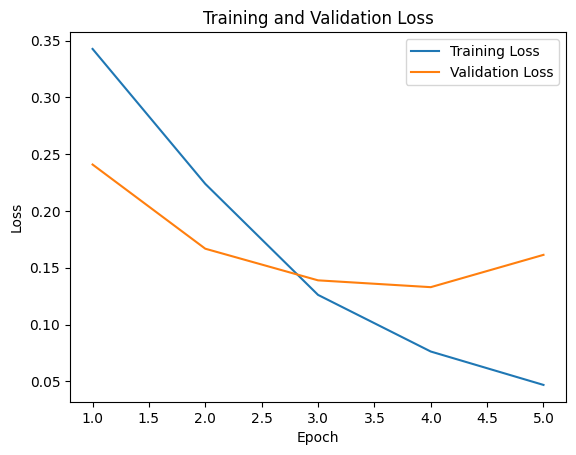

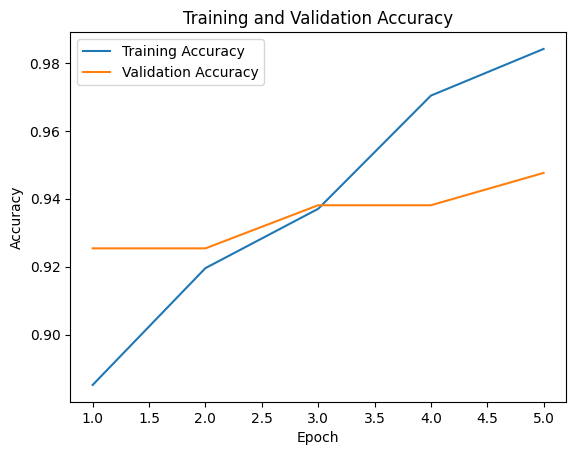

In [63]:
# Plot the training and validation loss
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [64]:
# model evaluation
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test data loader
for batch in test_dataloader:
    # Unpack the batch
    input_ids, attention_masks = batch

    # Move the tensors to the appropriate device
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    # Perform a forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)

    # Get the model predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    # Convert predictions to CPU and numpy arrays
    predictions = predictions.cpu().numpy()

    # Append predictions to the list
    all_predictions.extend(predictions)

In [65]:
# Test predictions
correct_sentiments = []

for review, prediction, actual_label in zip(X_test[10:20], all_predictions[10:20], y_test[10:20]):
    if prediction == actual_label:
        sentiment = "Correct"
    else:
        sentiment = "Incorrect"
    correct_sentiments.append(sentiment)
    print("Review:", review)
    print("Prediction:", prediction)
    print("Actual Sentiment:", actual_label)
    print("Sentiment Prediction:", sentiment)
    print()


Review: las películas no tiene o no se pueden cambiar a español o títulos en español
Prediction: 1
Actual Sentiment: 0
Sentiment Prediction: Incorrect

Review: Thought it would be more powerful and have a lot more functionality. Not much better than the Echo dot. Not worth the money.
Prediction: 1
Actual Sentiment: 0
Sentiment Prediction: Incorrect

Review: Worked as advertised. Thanks
Prediction: 1
Actual Sentiment: 1
Sentiment Prediction: Correct

Review: Easy set up and to use. I bought two one for my house and one for my 75 year old grandfather. I set it up for him a gave him a 15 minute lesson and he calls me at least once a day it’s is great to be able to see him in between visits.
Prediction: 1
Actual Sentiment: 1
Sentiment Prediction: Correct

Review: Still love it
Prediction: 1
Actual Sentiment: 1
Sentiment Prediction: Correct

Review: I didn't like that almost everytime i asked Alexa a question she would say i dont know that or i havent learned that.
Prediction: 0
Actual Sent